In [1]:
import OpenEXR, Imath, os
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

c:\Users\shins\Anaconda3\envs\HyperImaging\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Bring Depth(Distance) map

In [2]:
output_dir = "C:/Users/shins/HyperImaging/Dataset/data/result"

def read_exr_as_np(i, rendertype):
        """  Read exr file(rgb rendered obj scene) as numpy array
        
        exr file shape RGBA 640x640x4
        return : numpy array        
        """
        
        fn = os.listdir(output_dir)
        fn = [file for file in fn if rendertype in file]
        
        fn = os.path.join(output_dir, fn[i])

        f = OpenEXR.InputFile(fn)
        channels = f.header()['channels']
 
        dw = f.header()['dataWindow']
        size = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1)

        ch_names = []

        image = np.zeros((size[1], size[0], len(channels)-1))

        for i, ch_name in enumerate(channels):
            ch_names.append(ch_name)
            ch_dtype = channels[ch_name].type
            ch_str = f.channel(ch_name, ch_dtype)

            if ch_dtype == Imath.PixelType(Imath.PixelType.FLOAT):
                np_dtype = np.float32

            image_ch = np.fromstring(ch_str, dtype=np_dtype)
            image_ch.shape = (size[1], size[0])

            if ch_name == "A" :
                continue
            else:
                image[:,:,3-i] = image_ch
        
        return image

In [3]:
dist = read_exr_as_np(0,"Depth").astype(np.float32)
dist = dist[...,0]
sensor_width = 5.32e-3 
focal_length = 16e-3 
N = 640
x, y = np.meshgrid(np.linspace(-sensor_width/2, sensor_width/2, N), np.linspace(-sensor_width/2, sensor_width/2, N))
depth = focal_length *dist / np.sqrt(x**2 + y**2 + focal_length**2)

c:\Users\shins\Anaconda3\envs\HyperImaging\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [4]:
# plt.figure()
# plt.imshow(depth)
# plt.colorbar()

In [5]:
print(depth.max(), depth.min())

0.14000000925648473 0.09059517587604828


In [6]:
# set depth to real meters 1~1.4m
depth_to_meter = 10
depth *= depth_to_meter

In [7]:
print(depth.min(), depth.max()) # 1m ~ 1.4m where object is in WC

0.9059517587604827 1.4000000925648473


In [8]:
# bring only R values since RGB values are all the same
depth = torch.tensor(depth)

R,C = depth.shape

## Unprojection, Projection

In [9]:
xs = torch.linspace(0, R-1, steps=R)
ys = torch.linspace(0, C-1, steps=C)
c, r = torch.meshgrid(xs, ys, indexing='ij')

In [10]:
# plt.subplot(121), plt.imshow(r), plt.colorbar()
# plt.subplot(122), plt.imshow(c), plt.colorbar()

In [11]:
cam_pitch = sensor_width/N
print('cam pitch', cam_pitch)
x_c, y_c = (r-R/2)*cam_pitch, (c-R/2)*cam_pitch

z_c = torch.zeros_like(x_c)
z_c[:] = -focal_length

cam pitch 8.3125e-06


In [12]:
X,Y,Z = (-x_c/focal_length)*depth, (-y_c/focal_length)*depth, depth
# plt.figure(figsize=(15,5))
# plt.subplot(131), plt.imshow(X), plt.colorbar()
# plt.subplot(132), plt.imshow(Y), plt.colorbar()
# plt.subplot(133), plt.imshow(Z), plt.colorbar()

In [13]:
X,Y,Z = X.flatten(), Y.flatten(), Z.flatten()
XYZ1 = torch.stack((X,Y,Z, torch.ones_like(X)), dim = 1).transpose(1,0)

In [14]:
XYZ1.shape

torch.Size([4, 409600])

In [15]:
# bring parameters(numpy array)

param_path = 'C:/Users/shins/HyperImaging/Calibration/parameters'

proj_int = np.load(os.path.join(param_path, 'proj_int.npy')) # unit um
cam_proj_tvec = np.load(os.path.join(param_path, 'cam_proj_tvec.npy')) # unit mm


In [16]:
proj_int

array([[2.02636127e+03, 0.00000000e+00, 6.41597887e+02],
       [0.00000000e+00, 2.04296197e+03, 6.88201132e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [17]:
# proj intrinsic matrix
focal_length_proj = 8e-3 # proj intrinsic * pitch
sensor_diag_proj = 5.842e-3
sensor_width_proj = np.sin(np.arctan2(720, 1280))*sensor_diag_proj  # height
N_proj = 720
proj_pitch = sensor_width_proj/N_proj
proj_fov = np.rad2deg(np.arctan2(sensor_width_proj/2, focal_length_proj))
print("proj fov:", 2*proj_fov)

proj fov: 20.29766953435788


In [18]:
# proj extrinsic matrix
proj_extrinsic = np.zeros((3,4))
# no rotation
proj_extrinsic[0,0] = 1 
proj_extrinsic[1,1] = 1
proj_extrinsic[2,2] = 1

# translate + x 50e-3
proj_extrinsic[0,3] = 50e-3 

In [19]:
# change to tensor
proj_extrinsic = torch.tensor(proj_extrinsic)

In [20]:
# world coord (XYZ) in projector view
XYZ_proj = proj_extrinsic@XYZ1
XYZ_proj.shape

torch.Size([3, 409600])

In [21]:
np.save('./xyz_proj.npy',XYZ_proj)

In [22]:
# Check XYZ
# XYZ_proj_reshape = XYZ_proj.transpose(0,1).reshape(640,640,3)
# plt.figure(figsize=(10,5))
# plt.imshow(XYZ_proj_reshape[:,:,2]), plt.colorbar()

In [23]:
# world coord to proj sensor
rc_proj = (-focal_length_proj*XYZ_proj[:2,:]/XYZ_proj[2,:])/proj_pitch + N_proj/2

In [24]:
# xy_proj = (-focal_length_proj*XYZ_proj[:2,:]/XYZ_proj[2,:])

In [25]:
# xy_proj

In [26]:
rc_proj.shape

torch.Size([2, 409600])

In [27]:
640*640

409600

In [28]:
rc_proj = rc_proj.transpose(0,1).reshape(R,C,2)

(<AxesSubplot:>,
 <matplotlib.colorbar.Colorbar at 0x1a7a4cfc248>)

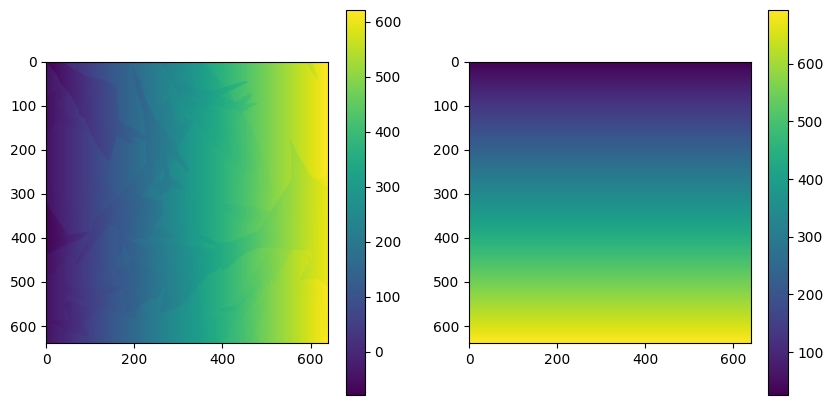

In [29]:
plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(rc_proj[:,:,0]), plt.colorbar()
plt.subplot(122),plt.imshow(rc_proj[:,:,1]), plt.colorbar()

(<AxesSubplot:>,
 <matplotlib.colorbar.Colorbar at 0x1a7a93a1a88>)

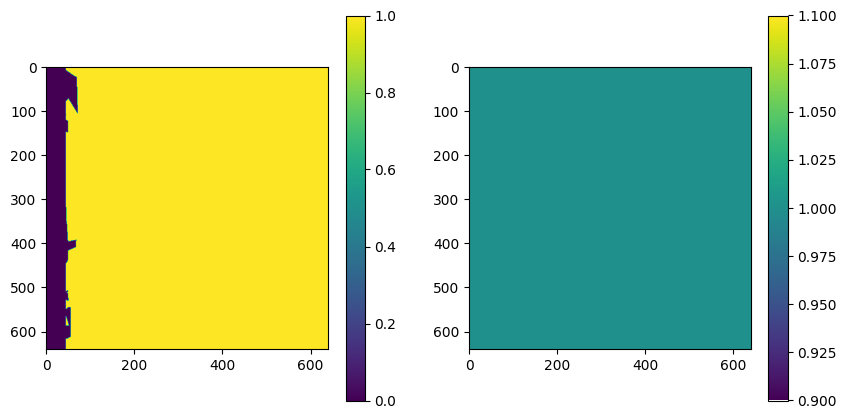

In [30]:
plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow((0<= rc_proj[:,:,0])*(rc_proj[:,:,0] <N_proj)), plt.colorbar()
plt.subplot(122), plt.imshow((0<=rc_proj[:,:,1])*(rc_proj[:,:,1]<N_proj)), plt.colorbar()

## Bring Illumination

In [31]:
illum_path = "C:/Users/shins/HyperImaging/Calibration/patterns/graycode_pattern"
illum = cv2.imread(os.path.join(illum_path, "pattern_12.png")).astype(np.float32)
illum = torch.tensor(illum)

In [32]:
illum.shape[0]

720

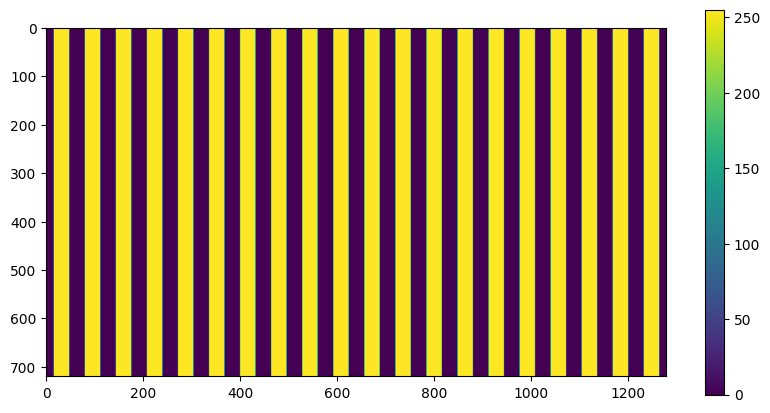

In [33]:
plt.figure(figsize=(10,5))
plt.imshow(illum[:,:,0])
plt.colorbar()

In [34]:
illum = illum.reshape(720*1280,3)
illum.shape

torch.Size([921600, 3])

In [35]:
mask_0 = (illum[:,:] < 150)
mask_1 = (illum[:,:] >= 150)

ill = np.ma.array(illum, mask = mask_0)
ill = ill.filled(fill_value = 0.0)

ill = np.ma.array(ill, mask= mask_1)
ill = ill.filled(fill_value = 1.0)

ill = ill.reshape(720,1280, 3)

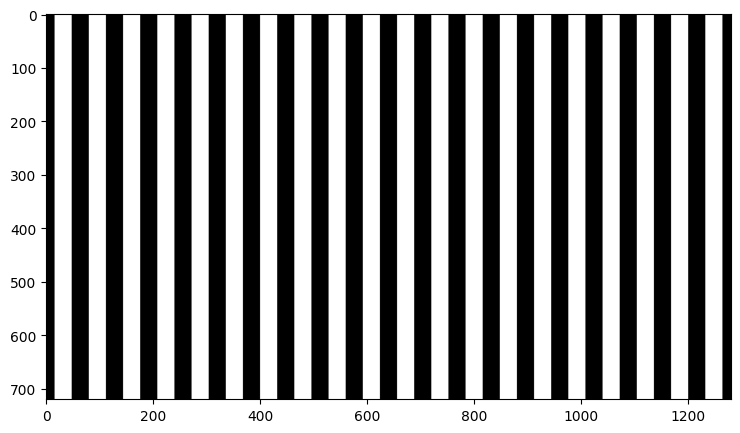

In [36]:
plt.figure(figsize = (10,5))
plt.imshow(ill)

In [37]:
print('x:',rc_proj[:,:,0],'\ny:',rc_proj[:,:,1])

x: tensor([[-77.3869, -76.4070, -75.3736,  ..., 619.3798, 620.4247, 621.4695],
        [-46.1759, -76.3119, -75.3186,  ..., 619.3799, 620.4247, 621.4695],
        [-46.1759, -45.1311, -75.2370,  ..., 619.3799, 620.4247, 621.4695],
        ...,
        [-46.1759, -45.1311, -44.0862,  ..., 619.3799, 620.4247, 621.4695],
        [-46.1759, -45.1311, -44.0863,  ..., 619.3799, 620.4247, 621.4695],
        [-46.1759, -45.1311, -44.0863,  ..., 619.3798, 620.4247, 621.4695]],
       dtype=torch.float64) 
y: tensor([[ 25.6549,  25.6549,  25.6549,  ...,  25.6549,  25.6549,  25.6549],
        [ 26.6997,  26.6997,  26.6997,  ...,  26.6997,  26.6997,  26.6997],
        [ 27.7445,  27.7445,  27.7445,  ...,  27.7445,  27.7445,  27.7445],
        ...,
        [691.2106, 691.2106, 691.2106,  ..., 691.2106, 691.2106, 691.2106],
        [692.2555, 692.2555, 692.2555,  ..., 692.2555, 692.2555, 692.2555],
        [693.3003, 693.3003, 693.3003,  ..., 693.3003, 693.3003, 693.3003]],
       dtype=torch.float6

In [55]:
print('max :', rc_proj[:,:,0].max().long(), 'min:', rc_proj[:,:,0].min().long())

max : tensor(621) min: tensor(-78)


In [56]:
print('max :', rc_proj[:,:,1].max().long(), 'min:', rc_proj[:,:,1].min().long())

max : tensor(693) min: tensor(25)


In [ ]:
print('max :', rc_proj[:,:,0].max(), 'min:', rc_proj[:,:,0].min())

In [38]:
rc_proj[:,:,0].long()

tensor([[-77, -76, -75,  ..., 619, 620, 621],
        [-46, -76, -75,  ..., 619, 620, 621],
        [-46, -45, -75,  ..., 619, 620, 621],
        ...,
        [-46, -45, -44,  ..., 619, 620, 621],
        [-46, -45, -44,  ..., 619, 620, 621],
        [-46, -45, -44,  ..., 619, 620, 621]])

In [47]:
illum_img = ill[rc_proj[:,:,1].long(), rc_proj[:,:,0].long()]

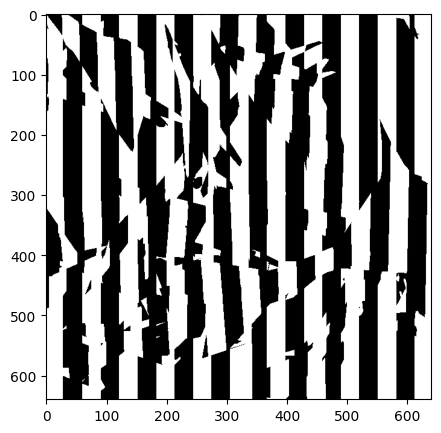

In [40]:
plt.figure(figsize=(10,5))
plt.imshow(illum_img[:,:,:])

In [42]:
illum_img

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [0., 0., 0.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]], dtype=float32)

## Bring occlusion map

In [ ]:
occlusion = read_exr_as_np(0, "Occlusion").astype(np.float32)
occlusion = torch.tensor(occlusion)

plt.figure(figsize=(10,5))
plt.imshow(occlusion[:,:,0])
plt.colorbar()

In [ ]:
occlusion = occlusion.reshape(640*640,3)
occlusion.shape
occlusion.mean()

In [ ]:
mask_0 = (occlusion[:,:] <= 0.8)  #  0.5보다 작은 숫자들 즉, true 인 곳에 0을 넣기
mask_1 = (occlusion[:,:] > 0.8)

occ = np.ma.array(occlusion, mask=mask_0)
occ = occ.filled(fill_value=0.0)

occ = np.ma.array(occ, mask=mask_1)
occ = occ.filled(fill_value=1.0)

occ = occ.reshape(640,640,3)

In [ ]:
plt.figure(figsize=(10,5))
plt.imshow(occ), plt.colorbar()

## Illum with Occlusion

In [ ]:
illum_img.shape

In [ ]:
occ.shape

In [ ]:
illum_img_w_occ = illum_img * occ

plt.figure(figsize=(10,5))
plt.imshow(illum_img_w_occ)

In [ ]:
type(illum_img_w_occ)